### Read data

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.datasets import load_svmlight_file
import pandas as pd
from time import time

def get_data():
    # Assuming 'farm-ads-vect' is in SVMlight format
    X, y = load_svmlight_file('data/farm-ads-vect')

    # Convert sparse matrix to DataFrame
    df_vectors = pd.DataFrame.sparse.from_spmatrix(X)

    return df_vectors, y

In [3]:
df, labels = get_data()

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54867,54868,54869,54870,54871,54872,54873,54874,54875,54876
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(4143, 54877)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a logistic regression model on the test data.

    Parameters:
    - model: trained logistic regression model
    - X_test: DataFrame, feature vectors for testing
    - y_test: Series, true labels for testing

    Returns:
    - accuracy: float, accuracy of the model on the test set
    - report: str, classification report (includes precision, recall, f1-score, and support)
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, f1


def train_knn(X_train, y_train, n_neighbors=5):
    """
    Train a k-nearest neighbors (KNN) model on the training data.

    Parameters:
    - X_train: DataFrame, feature vectors for training
    - y_train: Series, labels for training
    - n_neighbors: int, number of neighbors to consider (default is 5)

    Returns:
    - model: trained KNN model
    """
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

In [7]:
from typing import List


def evaluate_attribute_set(attribute_names: List[str], df, labels):
    df_temp = df[attribute_names]

    X_train, X_val, y_train, y_val = train_test_split(df_temp, labels, test_size=0.2, random_state=42)

    # Train the logistic regression model
    model = train_knn(X_train, y_train)

    # Evaluate the model
    accuracy, f1 = evaluate_model(model, X_val, y_val)

    return accuracy, f1

In [8]:
def sequential_forward_selection(df, labels, max_features=None):
    """
    Perform Sequential Forward Selection (SFS) for feature selection.

    Parameters:
    - X_train: DataFrame, feature vectors for training
    - y_train: Series, labels for training
    - X_test: DataFrame, feature vectors for testing
    - y_test: Series, true labels for testing
    - max_features: int, maximum number of features to select (default is None)

    Returns:
    - best_features: list, selected features
    """
    num_features = df.shape[1]
    all_features = list(df.columns)
    selected_features = []
    best_accuracy = 0.0
    best_f1 = 0.0

    df_performance = pd.DataFrame(columns=["selected_features", "num_selected_features", "time", "accuracy_validate"])
    start_time = time()
    while len(selected_features) < num_features and (max_features is None or len(selected_features) < max_features):
        time_start_new_feature = time()
        remaining_features = [feature for feature in all_features if feature not in selected_features]
        current_best_feature = None

        for feature in remaining_features:  # iterate over all remaining feature
            trial_features = selected_features + [feature]
            accuracy, f1 = evaluate_attribute_set(trial_features, df, labels)

            if accuracy > best_accuracy and f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                current_best_feature = feature

        if current_best_feature is not None:
            selected_features.append(current_best_feature)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy with Selected Features: {best_accuracy:.2f}")

            # Update the condition to ensure it only happens when a feature is added.
            df_performance = pd.concat([df_performance, pd.DataFrame({
                "selected_features": [selected_features.copy()],  # Ensuring this is a list of lists
                "num_selected_features": [len(selected_features)],
                "time_of_feature_selection": [time() - time_start_new_feature],
                "time": [time() - start_time],
                "accuracy_validate": [best_accuracy],
                "f1_validate": [best_f1]
            })])
        else:  # if no better feature than current best, have been found among the remaining features, return the dataset
            return selected_features, best_accuracy, best_f1, df_performance

    return selected_features, best_accuracy, best_f1, df_performance

In [9]:
N_OF_FEATURES_TO_TEST = 1000
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:N_OF_FEATURES_TO_TEST], labels, test_size=0.2, random_state=42)

In [14]:
selected_features, best_accuracy, best_f1, df_performance = sequential_forward_selection(X_train, y_train, max_features=22)
# algorithm stopped after choosing 22 features
selected_features, best_accuracy

Selected Features: [15]
Accuracy with Selected Features: 0.64
Selected Features: [15, 314]
Accuracy with Selected Features: 0.72
Selected Features: [15, 314, 428]
Accuracy with Selected Features: 0.75
Selected Features: [15, 314, 428, 387]
Accuracy with Selected Features: 0.78
Selected Features: [15, 314, 428, 387, 141]
Accuracy with Selected Features: 0.79
Selected Features: [15, 314, 428, 387, 141, 504]
Accuracy with Selected Features: 0.81
Selected Features: [15, 314, 428, 387, 141, 504, 707]
Accuracy with Selected Features: 0.81
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392]
Accuracy with Selected Features: 0.82
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392, 457]
Accuracy with Selected Features: 0.82
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392, 457, 351]
Accuracy with Selected Features: 0.83
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392, 457, 351, 461]
Accuracy with Selected Features: 0.83
Selected Features: [15, 314, 428, 387, 141,

KeyboardInterrupt: 

In [15]:
df_performance.to_csv("sfs_run_22_1000.csv", index=True)

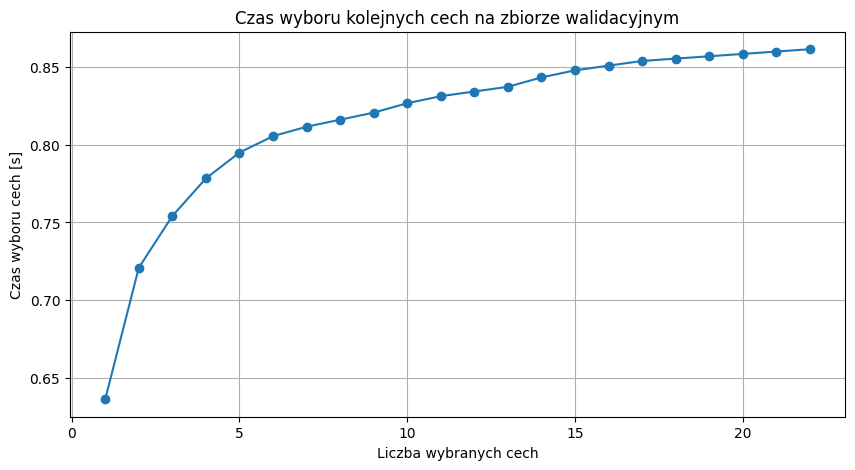

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(df_performance
['num_selected_features'], df_performance
['accuracy'], marker='o')

plt.title('Czas wyboru kolejnych cech na zbiorze walidacyjnym')
plt.xlabel('Liczba wybranych cech')
plt.ylabel('Czas wyboru cech [s]')
plt.grid(True)
plt.show()

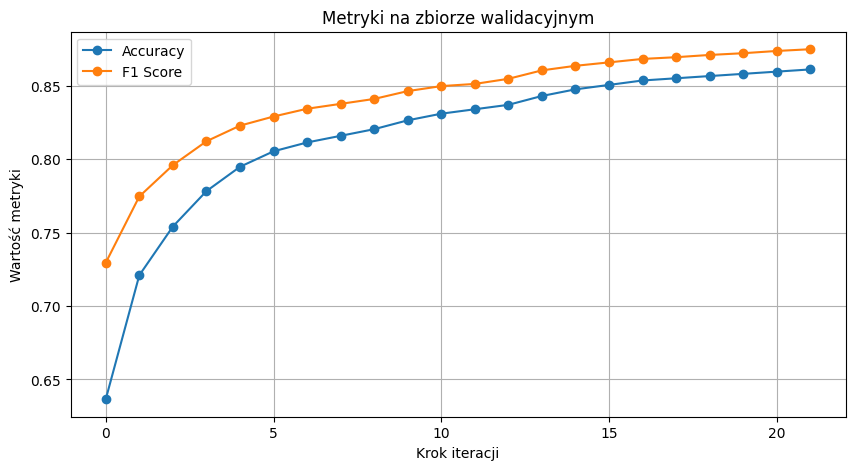

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(df_performance)), df_performance['accuracy'], marker='o', label='Accuracy')
plt.plot(range(len(df_performance)), df_performance['f1_score'], marker='o', label='F1 Score')

plt.title('Metryki na zbiorze walidacyjnym')
plt.xlabel('Krok iteracji')
plt.ylabel('Wartość metryki')
plt.legend()
plt.grid(True)
plt.show()

### Test solution

In [10]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a logistic regression model on the test data.

    Parameters:
    - model: trained logistic regression model
    - X_test: DataFrame, feature vectors for testing
    - y_test: Series, true labels for testing

    Returns:
    - accuracy: float, accuracy of the model on the test set
    - report: str, classification report (includes precision, recall, f1-score, and support)
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, f1

def train_knn(X_train, y_train, n_neighbors=5):
    """
    Train a k-nearest neighbors (KNN) model on the training data.

    Parameters:
    - X_train: DataFrame, feature vectors for training
    - y_train: Series, labels for training
    - n_neighbors: int, number of neighbors to consider (default is 5)

    Returns:
    - model: trained KNN model
    """
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

In [ ]:
df_test = pd.DataFrame(columns=['accuracy', 'f1', 'num_selected_features'])
for selected_features in df_performance['selected_features']:
    X_train_t = X_train[selected_features]
    # train model
    model = train_knn(X_train_t, y_train)
    accuracy, f1 = evaluate_model(model, X_test[selected_features], y_test)

    df_temp = pd.DataFrame(columns=['accuracy', 'f1', 'num_selected_features'],
        data = [[accuracy, f1, len(selected_features)]])
    df_test = pd.concat([df_test,df_temp])

In [22]:
df_test.to_csv("history_sfs.csv", index=False)

In [88]:
df_test

,accuracy,f1,num_selected_features
0,0.682750,0.770706,1
0,0.741858,0.801484,2
0,0.762364,0.812915,3
0,0.774427,0.820709,4
0,0.781665,0.824442,5
0,0.781665,0.824442,6
0,0.781665,0.824782,7
0,0.781665,0.824442,8
0,0.785283,0.826848,9
0,0.784077,0.825366,10


## Simulated annealing

In [77]:
import random
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from time import time

def simulated_annealing(df, labels, initial_temp, final_temp, alpha, max_iter):
    """
    Perform Simulated Annealing for feature selection.

    Parameters:
    df : DataFrame
        The dataset containing all potential features.
    labels : Series or array-like
        The target variable for the dataset.
    initial_temp : float
        The initial temperature for the annealing process.
    final_temp : float
        The final temperature at which the annealing process will stop.
    alpha : float
        The cooling rate of the temperature after each iteration.
    max_iter : int
        The maximum number of iterations to perform.

    Returns:
    best_set : list
        The best set of features found.
    best_accuracy : float
        The best accuracy achieved with the best set of features.
    best_f1 : float
        The best F1 score achieved with the best set of features.
    df_benchmark : DataFrame
        A DataFrame recording the benchmark data of each iteration, including feature count, feature set, accuracy, F1 score, and other relevant metrics.
    """
    BENCHMARK_COLS = ["Iteration", "Feature Count", "Feature Set", "Accuracy", "F1", "Acceptance Probability", "Random Number", "Operation", "Improved", "curr_temp"]
    df_benchmark = pd.DataFrame(columns=BENCHMARK_COLS)

    current_temp = initial_temp
    num_features = df.shape[1]
    all_features = list(df.columns)
    current_set = random.sample(all_features, k=random.randint(1, num_features))  # Random initial set

    best_set = current_set.copy()
    best_accuracy, best_f1 = evaluate_attribute_set(best_set, df, labels)

    for iteration in range(max_iter):
        if current_temp <= final_temp:
            break

        new_set, operation = make_random_change(current_set, all_features)
        accuracy, f1 = evaluate_attribute_set(new_set, df, labels)

        decision, random_num, probability = accept_change(best_accuracy, accuracy, current_temp)
        if decision:
            current_set = new_set.copy()
            if accuracy > best_accuracy:
                best_set = current_set
                best_accuracy = accuracy
                best_f1 = f1

        current_temp *= alpha  # Cooling step

        # "Iteration", "Feature Count", "Feature Set", "Accuracy", "F1", "Acceptance Probability", "Random Number", "Operation", "Improved"
        iteration_data = pd.DataFrame(columns=BENCHMARK_COLS,
                                      data=[[iteration, len(current_set), str(current_set), accuracy, f1, probability, random_num, operation, int(decision), current_temp]])

        df_benchmark = pd.concat([df_benchmark, iteration_data]).reset_index(drop=True)
    return best_set, best_accuracy, best_f1, df_benchmark

def make_random_change(current_set, all_features):
    """
    Make a random change to the current set of features.

    Parameters:
    current_set : list
        The current set of selected features.
    all_features : list
        The list of all possible features.

    Returns:
    current_set : list
        The modified set of features after the random change.
    operation : str
        The type of operation performed ('add', 'remove', or 'swap').
    """
    operation = random.choice(["add", "remove", "swap"])
    if operation == "add":
        # Add a random feature not in the current set
        possible_additions = list(set(all_features) - set(current_set))
        if possible_additions:
            feature_to_add = random.choice(possible_additions)
            current_set.append(feature_to_add)
    elif operation == "remove":
        # Remove a random feature from the current set
        if current_set:
            feature_to_remove = random.choice(current_set)
            current_set.remove(feature_to_remove)
    elif operation == "swap":
        # Swap a feature in the set with one outside it
        if current_set and len(all_features) > len(current_set):
            feature_to_remove = random.choice(current_set)
            current_set.remove(feature_to_remove)
            possible_additions = list(set(all_features) - set(current_set))
            feature_to_add = random.choice(possible_additions)
            current_set.append(feature_to_add)
    return current_set, operation

def accept_change(best_accuracy, new_accuracy, temperature):
    """
    Determine whether to accept the new set of features based on the Simulated Annealing acceptance criterion.

    Parameters:
    best_accuracy : float
        The best accuracy achieved so far.
    new_accuracy : float
        The accuracy achieved with the new set of features.
    temperature : float
        The current temperature in the annealing process.

    Returns:
    decision : bool
        A boolean indicating whether the new set of features is accepted.
    random_num : float
        A random number generated for the probabilistic decision.
    probability : float
        The calculated probability used to determine the acceptance of the new feature set.
    """
    probability = 0
    random_num = 0
    if new_accuracy > best_accuracy:
        decision = True # Always accept if the new solution is better
    else:
        # Calculate the probability of acceptance and accept based on it
        probability = np.exp((new_accuracy - best_accuracy) / temperature)
        random_num = random.random()
        decision = random.random() < probability
    return decision, random_num, probability

In [78]:
N_OF_FEATURES_TO_TEST = 1000
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:N_OF_FEATURES_TO_TEST], labels, test_size=0.2, random_state=42)

In [82]:
# Example usage
MAX_ITER=100

best_set, best_accuracy, best_f1, df_benchmark = simulated_annealing(X_train, y_train,
                                                                     initial_temp=0.5,
                                                                     final_temp=0.01,
                                                                     alpha=0.98,
                                                                     max_iter=MAX_ITER)
best_accuracy, best_f1

(0.8190045248868778, 0.828080229226361)

In [83]:
df_benchmark.to_csv("history_sa_3.csv", index=False)

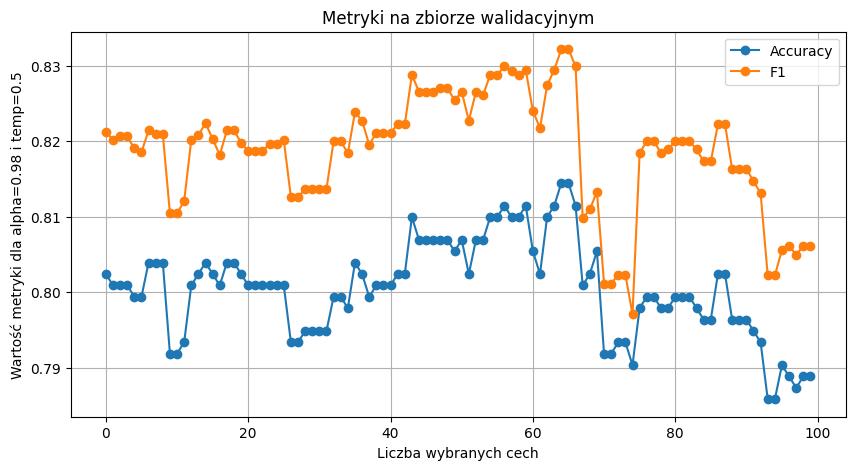

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(df_benchmark['Iteration'], df_benchmark
['Accuracy'], marker='o', label='Accuracy')
plt.plot(df_benchmark['Iteration'], df_benchmark
['F1'], marker='o', label='F1')

plt.title('Metryki na zbiorze walidacyjnym')
plt.xlabel('Liczba wybranych cech')
plt.ylabel('Wartość metryki dla alpha=0.98 i temp=0.5')
plt.legend()
plt.grid(True)
plt.show()

### Zbiór testowy

Poniższe kroki skupiają się na obliczeniu metryk dla zbioru cech wybranych w 3 iteracjach algorytmu SA

In [85]:
# Załadowanie wyników
df_sa_1 = pd.read_csv("history_sa_1.csv")
df_sa_2 = pd.read_csv("history_sa_2.csv")
df_sa_3 = pd.read_csv("history_sa_3.csv")

In [86]:
import ast

In [87]:
# należy wykonać 3 razy dla 3 różnych uruchomień z wybranymi atrybutami
testing_dataset = df_sa_3

df_test = pd.DataFrame(columns=['accuracy', 'f1', 'num_selected_features'])

features_set = testing_dataset['Feature Set'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)  # convert list from str to list with ints
for selected_features in features_set:
    X_train_t = X_train[selected_features]
    # train model
    model = train_knn(X_train_t, y_train)
    accuracy, f1 = evaluate_model(model, X_test[selected_features], y_test)

    df_temp = pd.DataFrame(columns=['accuracy', 'f1', 'num_selected_features'],
        data = [[accuracy, f1, len(selected_features)]])
    df_test = pd.concat([df_test,df_temp])
df_test.to_csv("history_sa_3_test.csv", index=False)

In [88]:
df_test

,accuracy,f1,num_selected_features
0,0.825090,0.848168,668
0,0.825090,0.848168,669
0,0.825090,0.848168,668
0,0.825090,0.848168,667
0,0.825090,0.848168,667
...,...,...,...
0,0.832328,0.853221,655
0,0.832328,0.853221,656
0,0.835947,0.856540,656
0,0.835947,0.856540,655


### Second implementation  -  WRONG
based on vector of ones and zeros to record which feature to choose

In [80]:
def simulated_annealing(df, labels, initial_temp, final_temp, alpha, num_features_target):
    num_features = df.shape[1]
    current_vector = np.random.choice([0, 1], size=num_features)
    # Ensure the initial vector has exactly num_features_target features
    current_vector = adjust_vector_to_target(current_vector, num_features_target)
    best_vector = current_vector.copy()

    best_accuracy, best_f1 = evaluate_attribute_set(best_vector, df, labels)

    current_temp = initial_temp
    while current_temp > final_temp:
        new_vector = make_random_change(current_vector.copy(), num_features_target)
        accuracy, f1 = evaluate_attribute_set(new_vector, df, labels)

        if accept_change(best_accuracy, accuracy, current_temp):
            current_vector = new_vector
            if accuracy > best_accuracy:
                best_vector = current_vector
                best_accuracy = accuracy
                best_f1 = f1

        current_temp *= alpha

    return best_vector, best_accuracy, best_f1

def make_random_change(current_vector, num_features_target):
    # Get indices where features are currently selected (1) and not selected (0)
    indices_with_1 = np.where(current_vector == 1)[0]
    indices_with_0 = np.where(current_vector == 0)[0]

    # Check if the number of selected features matches num_features_target
    if len(indices_with_1) > num_features_target:
        # More features selected than desired, randomly remove features
        indices_to_remove = np.random.choice(indices_with_1, size=(len(indices_with_1) - num_features_target), replace=False)
        current_vector[indices_to_remove] = 0
    elif len(indices_with_1) < num_features_target:
        # Fewer features selected than desired, randomly add features
        indices_to_add = np.random.choice(indices_with_0, size=(num_features_target - len(indices_with_1)), replace=False)
        current_vector[indices_to_add] = 1
    else:
        # Exactly num_features_target features are selected, perform a swap
        idx_to_remove = np.random.choice(indices_with_1)
        idx_to_add = np.random.choice(indices_with_0)
        current_vector[idx_to_remove] = 0
        current_vector[idx_to_add] = 1

    return current_vector

def adjust_vector_to_target(vector, num_features_target):
    # Adjust the vector to have exactly num_features_target features
    current_count = np.sum(vector)
    while current_count != num_features_target:
        if current_count < num_features_target:
            idx_to_add = np.random.choice(np.where(vector == 0)[0])
            vector[idx_to_add] = 1
        elif current_count > num_features_target:
            idx_to_remove = np.random.choice(np.where(vector == 1)[0])
            vector[idx_to_remove] = 0
        current_count = np.sum(vector)
    return vector

In [81]:
N_OF_FEATURES_TO_TEST = 100
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :N_OF_FEATURES_TO_TEST], labels, test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :N_OF_FEATURES_TO_TEST], labels, test_size=0.2,
                                                    random_state=42)

In [83]:
# Example usage
num_features_target = 5  # Set the number of features you want to select
selected_vector, accuracy, f1 = simulated_annealing(df, labels, initial_temp=1000, final_temp=1, alpha=0.95, num_features_target=num_features_target)

KeyboardInterrupt: 

# Porównanie metod

In [10]:
def aggregate_runs(df1, df2, df3):
    """
    Aggregates metrics: f1_score, accuracy through mean and standard deviation.
    :return:
    """
    # Concatenate the dataframes
    df_concat = pd.concat([df1, df2, df3], axis=1)

    # Calculate mean and std for f1_score and accuracy
    mean_f1_score = df_concat['f1_score'].mean(axis=1)
    std_f1_score = df_concat['f1_score'].std(axis=1)
    mean_accuracy = df_concat['accuracy'].mean(axis=1)
    std_accuracy = df_concat['accuracy'].std(axis=1)
    mean_num_f = df_concat['num_features'].mean(axis=1)
    std_num_f = df_concat['num_features'].std(axis=1)

    return mean_f1_score, std_f1_score, mean_accuracy, std_accuracy, mean_num_f, std_num_f

In [8]:
df_sfs = pd.read_csv("history_sfs.csv")

In [11]:
df_genetic_1 = pd.read_csv("history_run_genetic_1.csv", usecols=range(1, 4))[:100]
df_genetic_2 = pd.read_csv("history_run_genetic_2.csv", usecols=range(1, 4))[:100]
df_genetic_3 = pd.read_csv("history_run_genetic_3.csv", usecols=range(1, 4))[:100]

In [12]:
df_sa_1 = pd.read_csv("history_sa_1_test.csv")
df_sa_2 = pd.read_csv("history_sa_2_test.csv")
df_sa_3 = pd.read_csv("history_sa_3_test.csv")

In [16]:
genetic_mean_f1_score, genetic_std_f1_score, genetic_mean_accuracy, genetic_std_accuracy, genetic_mean_num_f, genetic_std_num_f = aggregate_runs(df_genetic_1, df_genetic_2, df_genetic_3)
sa_mean_f1_score, sa_std_f1_score, sa_mean_accuracy, sa_std_accuracy, sa_mean_num_f, sa_std_num_f = aggregate_runs(df_sa_1, df_sa_2, df_sa_3)
sfs_accuracy = df_sfs['accuracy']
sfs_f1_score = df_sfs['f1']
sfs_num_f = df_sfs['num_selected_features']

### Porównanie accuracy

In [17]:
import matplotlib.pyplot as plt

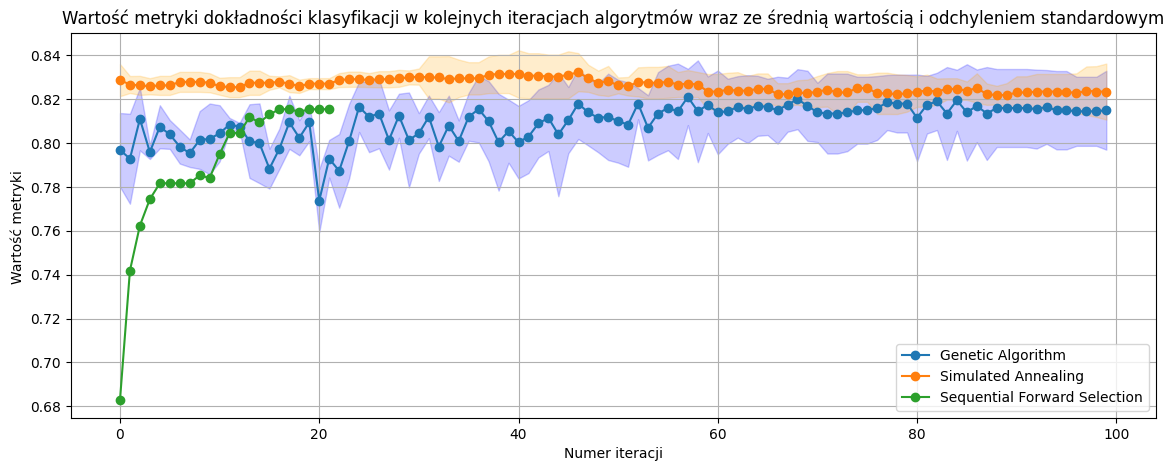

In [18]:
plt.figure(figsize=(14, 5))

iterations = range(len(df_genetic_1))

# Genetic algorithm
plt.plot(iterations, genetic_mean_accuracy, marker='o', label='Genetic Algorithm')
# Fill area for standard deviation
plt.fill_between(iterations,
                 genetic_mean_accuracy - genetic_std_accuracy,
                 genetic_mean_accuracy + genetic_std_accuracy, color='blue', alpha=0.2)


# Simulated Annealing
plt.plot(iterations, sa_mean_accuracy, marker='o', label='Simulated Annealing')
# Fill area for standard deviation
plt.fill_between(iterations,
                 sa_mean_accuracy - sa_std_accuracy,
                 sa_mean_accuracy + sa_std_accuracy, color='orange', alpha=0.2)

# Sequential Forward selection
plt.plot(range(len(sfs_accuracy)), sfs_accuracy, marker='o', label='Sequential Forward Selection')

plt.title('Wartość metryki dokładności klasyfikacji w kolejnych iteracjach algorytmów wraz ze średnią wartością i odchyleniem standardowym')
plt.xlabel('Numer iteracji')
plt.ylabel('Wartość metryki ')
plt.legend()
plt.grid(True)
plt.show()

### Porównanie współczynnika F1

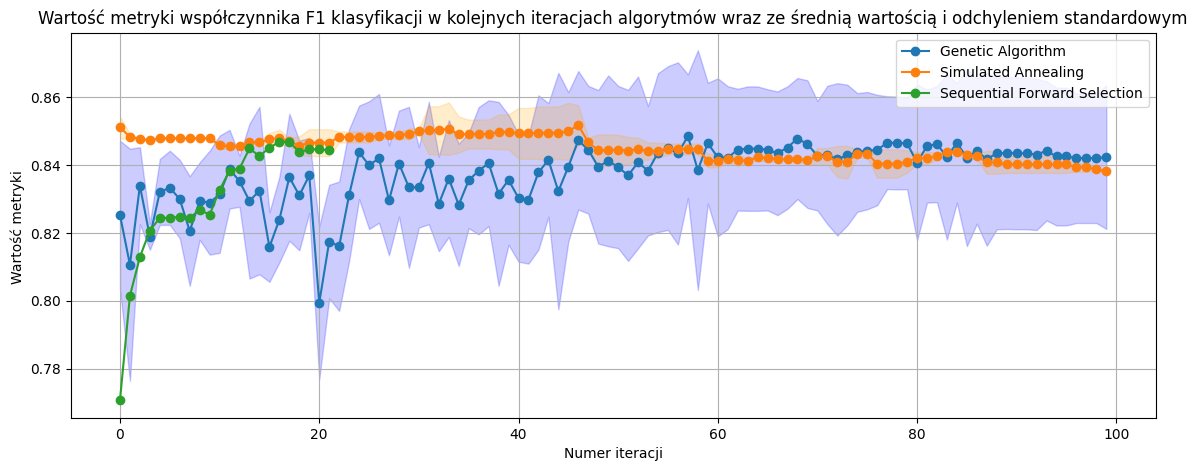

In [19]:
plt.figure(figsize=(14, 5))

iterations = range(len(df_genetic_1))

# Genetic algorithm
plt.plot(iterations, genetic_mean_f1_score, marker='o', label='Genetic Algorithm')
# Fill area for standard deviation
plt.fill_between(iterations,
                 genetic_mean_f1_score - genetic_std_f1_score,
                 genetic_mean_f1_score + genetic_std_f1_score, color='blue', alpha=0.2)


# Simulated Annealing
plt.plot(iterations, sa_mean_f1_score, marker='o', label='Simulated Annealing')
# Fill area for standard deviation
plt.fill_between(iterations,
                 sa_mean_f1_score - sa_std_f1_score,
                 sa_mean_f1_score + sa_std_f1_score, color='orange', alpha=0.2)

# Sequential Forward Selection
plt.plot(range(len(sfs_f1_score)), sfs_f1_score, marker='o', label='Sequential Forward Selection')

plt.title('Wartość metryki współczynnika F1 klasyfikacji w kolejnych iteracjach algorytmów wraz ze średnią wartością i odchyleniem standardowym')
plt.xlabel('Numer iteracji')
plt.ylabel('Wartość metryki ')
plt.legend()
plt.grid(True)
plt.show()

### Porównanie ilości wybranych atrybutów

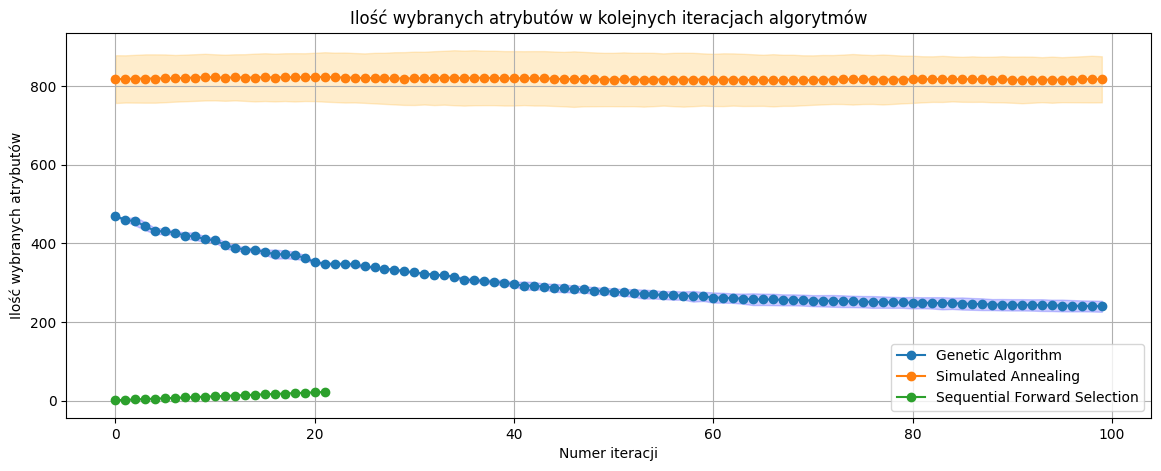

In [103]:
plt.figure(figsize=(14, 5))

iterations = range(len(df_genetic_1))

# Genetic algorithm
plt.plot(iterations, genetic_mean_num_f, marker='o', label='Genetic Algorithm')
# Fill area for standard deviation
plt.fill_between(iterations,
                 genetic_mean_num_f - genetic_std_num_f,
                 genetic_mean_num_f + genetic_std_num_f, color='blue', alpha=0.2)


# Simulated Annealing
plt.plot(iterations, sa_mean_num_f, marker='o', label='Simulated Annealing')
# Fill area for standard deviation
plt.fill_between(iterations,
                 sa_mean_num_f - sa_std_num_f,
                 sa_mean_num_f + sa_std_num_f, color='orange', alpha=0.2)

# Sequential Forward Selection
plt.plot(range(len(sfs_num_f)), sfs_num_f, marker='o', label='Sequential Forward Selection')

plt.title('Ilość wybranych atrybutów w kolejnych iteracjach algorytmów')
plt.xlabel('Numer iteracji')
plt.ylabel('Ilość wybranych atrybutów')
plt.legend()
plt.grid(True)
plt.show()

### Najlepsze wyniki

In [22]:
df_genetic = pd.concat([df_genetic_1, df_genetic_2, df_genetic_3], axis=0)
df_sa = pd.concat([df_sa_1, df_sa_2, df_sa_3], axis=0)

In [27]:
df_genetic['f1_score'].idxmax(), df_genetic['f1_score'].max()

(85, 0.8643147208121826)

In [28]:
df_genetic['accuracy'].idxmax(), df_genetic['accuracy'].max()

(85, 0.8371040723981901)

In [29]:
df_sa['f1_score'].idxmax(), df_sa['f1_score'].max()

(33, 0.85620915)

In [30]:
df_sa['accuracy'].idxmax(), df_sa['accuracy'].max()

(33, 0.840772014)

In [31]:
df_sfs['accuracy'].idxmax(), df_sfs['accuracy'].max()

(16, 0.8154402895054282)

In [33]:
df_sfs['f1'].idxmax(), df_sfs['f1'].max()

(16, 0.8468468468468469)